In [3]:
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [4]:
batch_size = 128
image_size = 64
device     = 'cuda' if torch.cuda.is_available() else 'cpu'
z_dim      = 64
nc         = 1
lr         = 0.0002
beta_1     = 0.5
beta_2     = 0.999
epochs     = 50
clip_value = 0.01
n_critic   = 5


In [5]:
class Generator(nn.Module):
  def __init__(self, z_dim,nc = 1,hidden_channels = 64):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        self.gen_block(z_dim,hidden_channels * 8, 4, 1, 0),
        self.gen_block(hidden_channels * 8,hidden_channels * 4),
        self.gen_block(hidden_channels * 4,hidden_channels * 2),
        self.gen_block(hidden_channels * 2,hidden_channels),
        nn.ConvTranspose2d(in_channels = hidden_channels, out_channels = nc, kernel_size  = 4, stride = 2,padding=1),
        nn.Tanh()
    )
  def gen_block(self,in_channels,out_channels,kernal_size = 4,stride = 2,padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d( in_channels  = in_channels,
                            out_channels = out_channels,
                            kernel_size  = kernal_size,
                            stride = stride,
                            padding = padding,
                            ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True)
    )
  def forward(self,x):
    x = x.view(len(x), self.z_dim, 1, 1)
    return self.gen(x)


In [6]:
class Critic(nn.Module):
  def __init__(self,nc = 1,hidden_channels = 64):
    super(Critic, self).__init__()
    self.crt = nn.Sequential(
            nn.Conv2d(nc, hidden_channels, 4, 2, 1),
            nn.LeakyReLU  (0.2, inplace=True),
            self.crt_block(hidden_channels,hidden_channels * 2),
            self.crt_block(hidden_channels * 2,hidden_channels * 4),
            self.crt_block(hidden_channels * 4,hidden_channels * 8),
            nn.Conv2d(hidden_channels * 8, 1 , 4, 1, 0)
            )
  def crt_block(self,in_channels,out_channels,kernal_size = 4,stride = 2,padding = 1):
    return nn.Sequential(
            nn.Conv2d(in_channels  = in_channels,
                      out_channels = out_channels,
                      kernel_size  = kernal_size,
                      stride  = stride,
                      padding = padding,
                      ),
             nn.BatchNorm2d(out_channels),
             nn.LeakyReLU(0.2, inplace=True)
            )
  def forward(self, x):
    pred = self.crt(x)

    return pred.view(len(pred), -1)


In [7]:
dataset_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,)),
])

In [8]:
dataloader = DataLoader(
        FashionMNIST(".", download=True, transform=dataset_transforms),
        batch_size=batch_size,
        shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 13241719.87it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209657.66it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3872975.33it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3138412.35it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



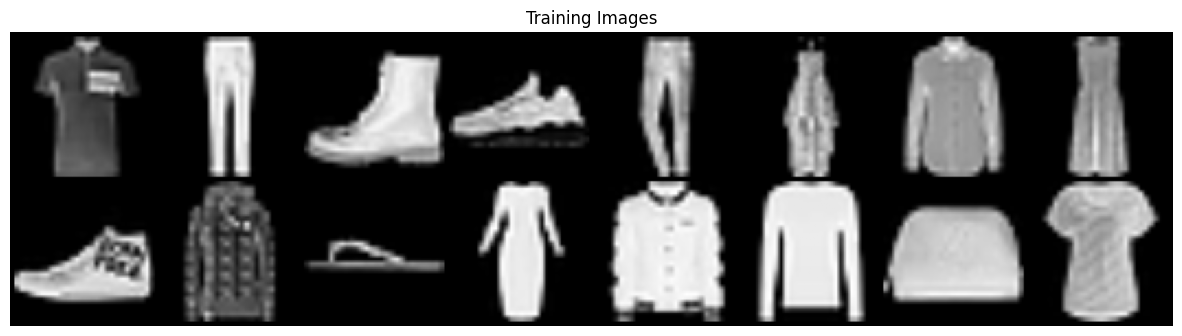

In [9]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:16].to(device), normalize=True).cpu(),(1,2,0)))

In [10]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [11]:
gen = Generator(z_dim).to(device)
crit = Critic(nc).to(device)

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crt_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))


  0%|          | 0/469 [00:00<?, ?it/s]

epoch 0/50 Generator loss =  0.0009745504302002474 Critic loss =  -0.0009804783599463099


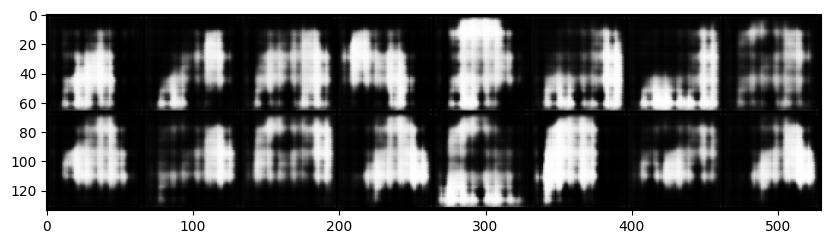

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 1/50 Generator loss =  0.0011053212415943268 Critic loss =  -0.001196438823935828


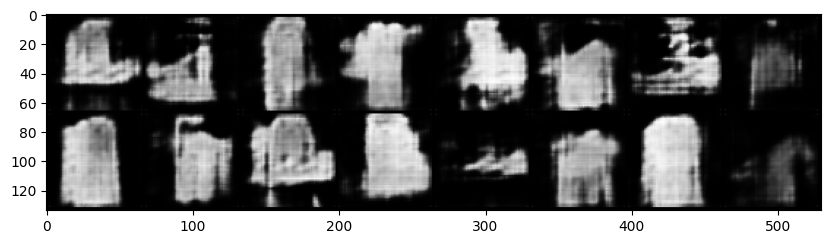

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 2/50 Generator loss =  0.0003475684092751444 Critic loss =  -0.0011077514335290709


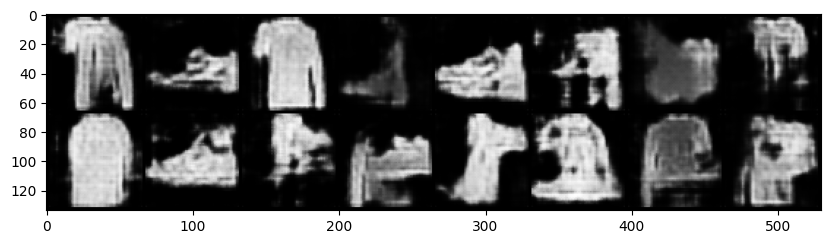

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 3/50 Generator loss =  0.0006326715320920639 Critic loss =  -0.0013023370872936777


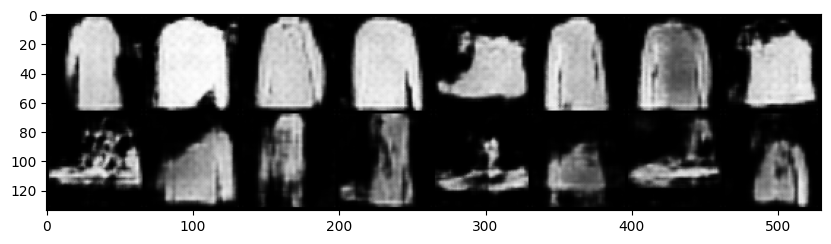

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 4/50 Generator loss =  0.0009451282303978894 Critic loss =  -0.0010937778934486894


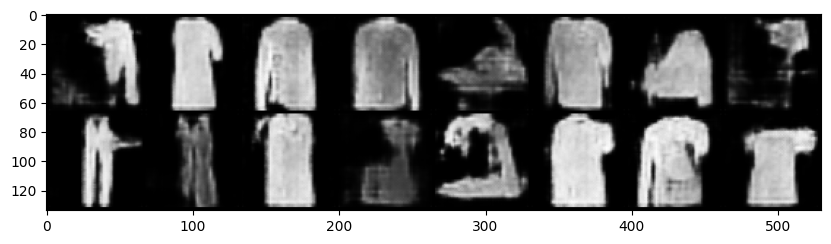

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 5/50 Generator loss =  0.000892511499461843 Critic loss =  -0.0009357515555709155


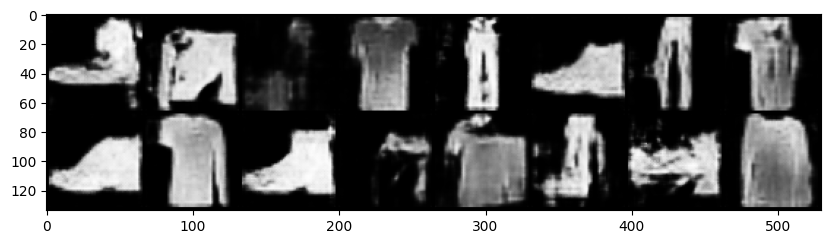

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 6/50 Generator loss =  0.0007888876171762755 Critic loss =  -0.0010523138397029721


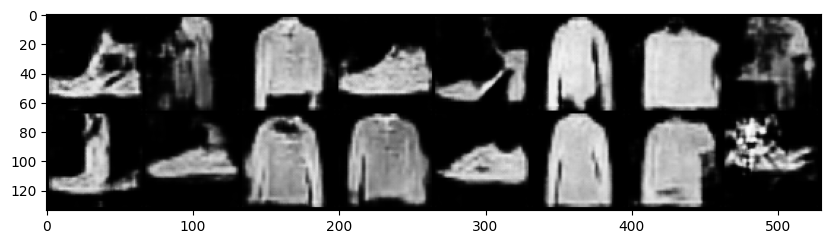

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 7/50 Generator loss =  0.00023619952931332945 Critic loss =  -0.0009835500961173573


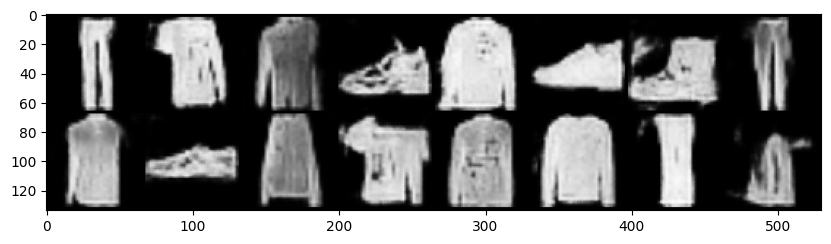

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 8/50 Generator loss =  0.00022073001114290153 Critic loss =  -0.0007807191119773556


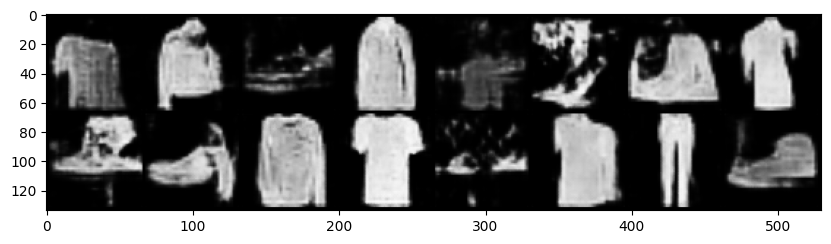

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 9/50 Generator loss =  7.371640980624949e-05 Critic loss =  -0.0008879704897337631


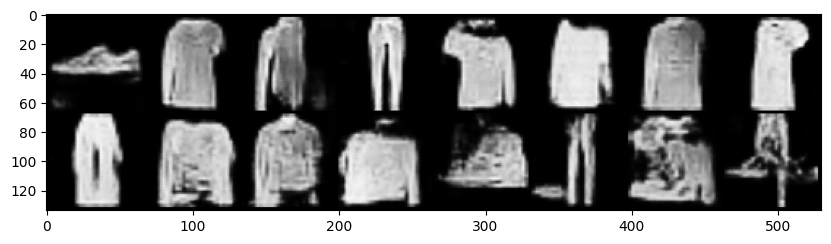

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 10/50 Generator loss =  0.000921685558392295 Critic loss =  -0.0007603267616808796


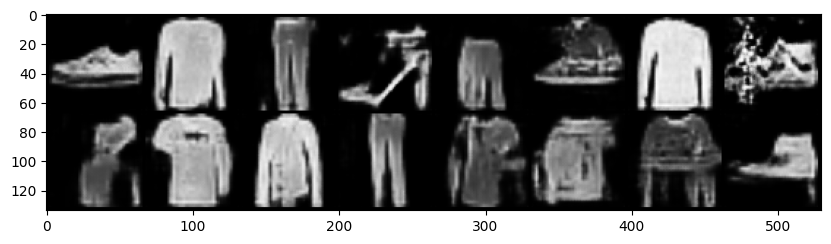

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 11/50 Generator loss =  0.0009074945693839587 Critic loss =  -0.00078716594527271


  0%|          | 0/469 [00:00<?, ?it/s]

epoch 12/50 Generator loss =  0.0008221620689831308 Critic loss =  -0.0006724627160314304


  0%|          | 0/469 [00:00<?, ?it/s]

epoch 13/50 Generator loss =  0.0004989926431224798 Critic loss =  -0.0006693483415697176


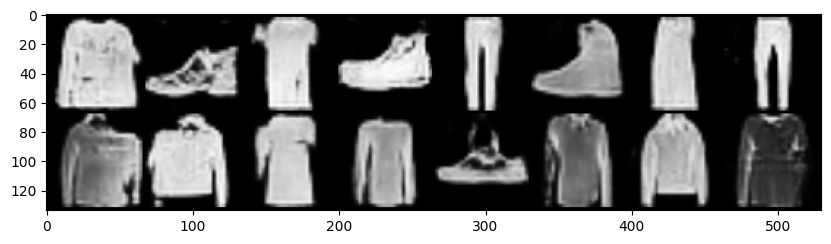

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 14/50 Generator loss =  0.0008266335611404386 Critic loss =  -0.0007668035243874166


  0%|          | 0/469 [00:00<?, ?it/s]

epoch 15/50 Generator loss =  0.00045827679288412714 Critic loss =  -0.0006751630987439837


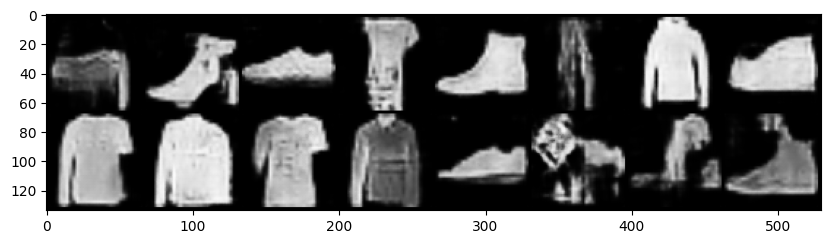

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 16/50 Generator loss =  0.0008418204179450647 Critic loss =  -0.0007878517799540115


  0%|          | 0/469 [00:00<?, ?it/s]

epoch 17/50 Generator loss =  0.0007945382391720184 Critic loss =  -0.0007954032055096332


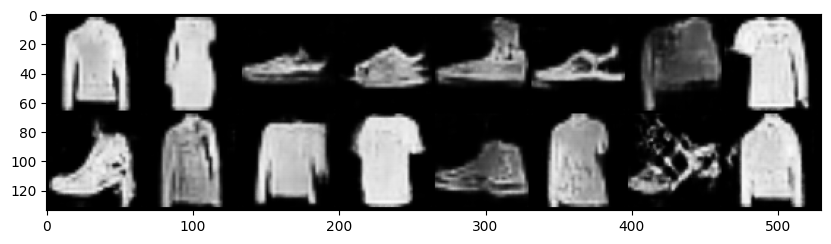

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 18/50 Generator loss =  2.740974873622089e-05 Critic loss =  -0.0006520652186387637


  0%|          | 0/469 [00:00<?, ?it/s]

epoch 19/50 Generator loss =  0.0007145254215451954 Critic loss =  -0.00068726697201922


  0%|          | 0/469 [00:00<?, ?it/s]

epoch 20/50 Generator loss =  0.00038068584287598696 Critic loss =  -0.0007278125550446988


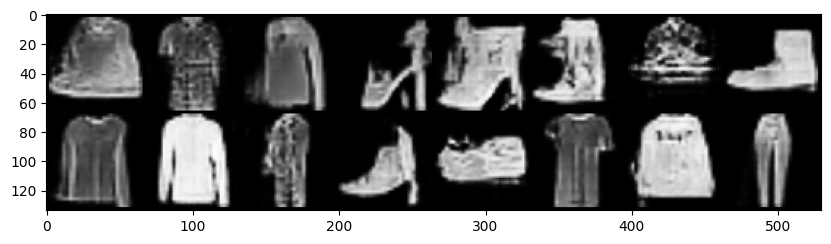

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 21/50 Generator loss =  -5.846668376343082e-05 Critic loss =  -0.0006707697661954965


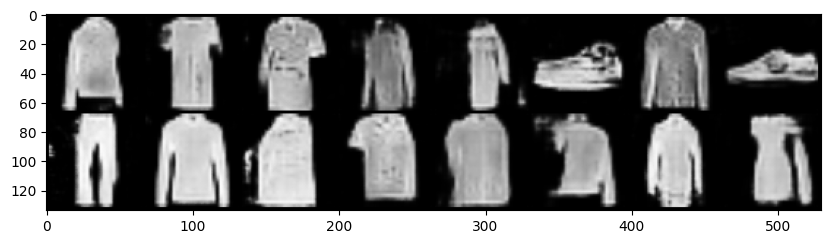

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 22/50 Generator loss =  4.9706969434010194e-05 Critic loss =  -0.0006774691249261787


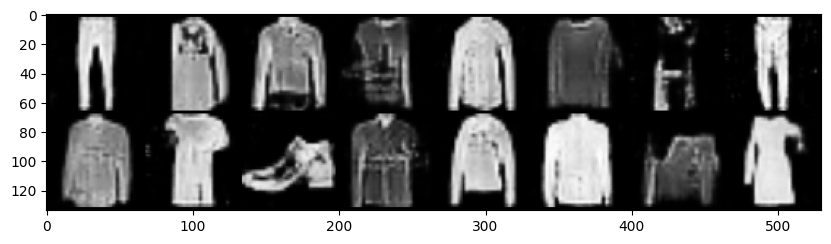

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 23/50 Generator loss =  0.0006143410068585166 Critic loss =  -0.0006020018286796521


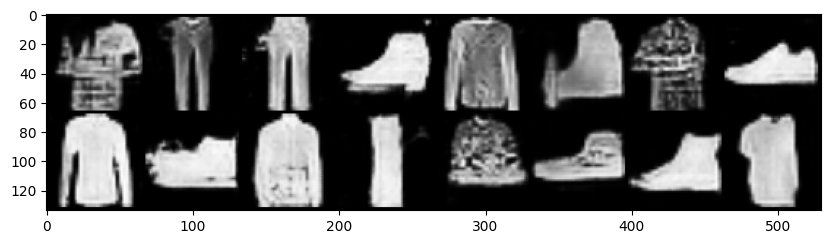

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 24/50 Generator loss =  0.0005584579032621404 Critic loss =  -0.0005556244585813999


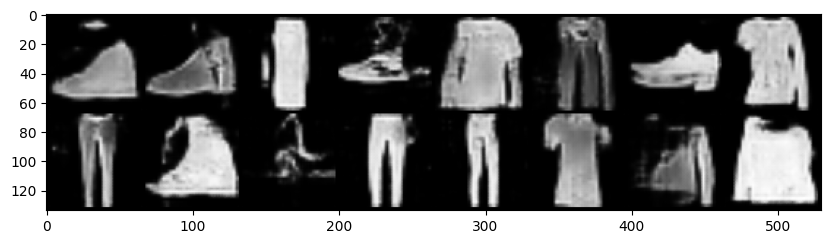

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 25/50 Generator loss =  0.0006138071068314347 Critic loss =  -0.0005364329067628776


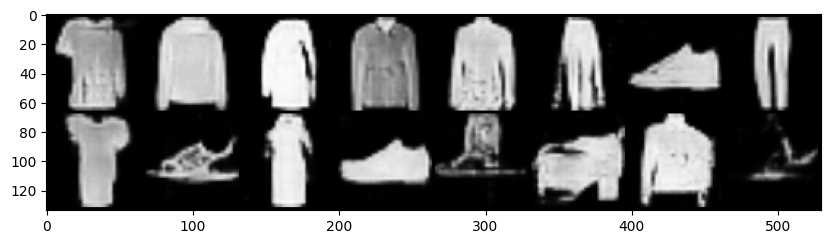

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 26/50 Generator loss =  0.0006726858204107549 Critic loss =  -0.0005464614835629331


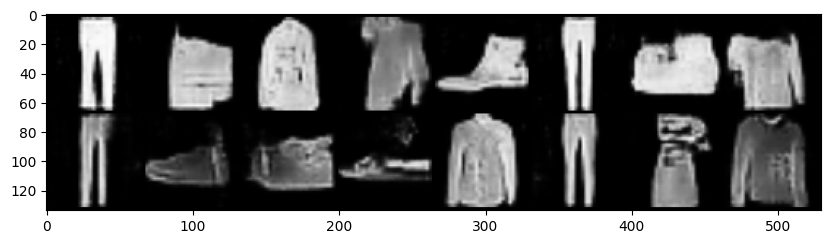

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 27/50 Generator loss =  -3.3938824367929876e-05 Critic loss =  -0.0006821119327789177


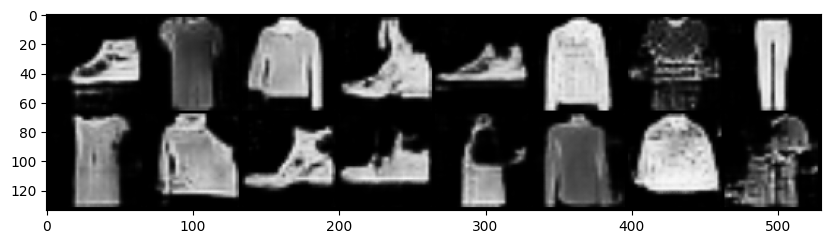

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 28/50 Generator loss =  0.00037611328335459046 Critic loss =  -0.0007444834912509553


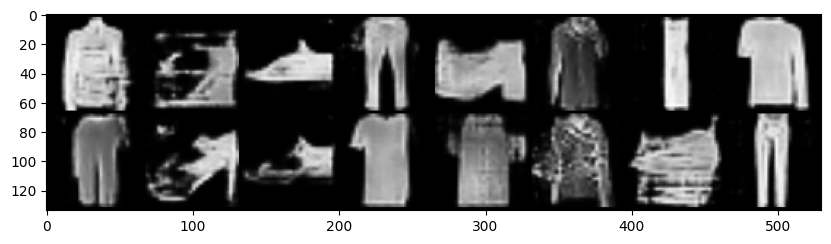

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 29/50 Generator loss =  0.0005676173197943519 Critic loss =  -0.0005231445023754258


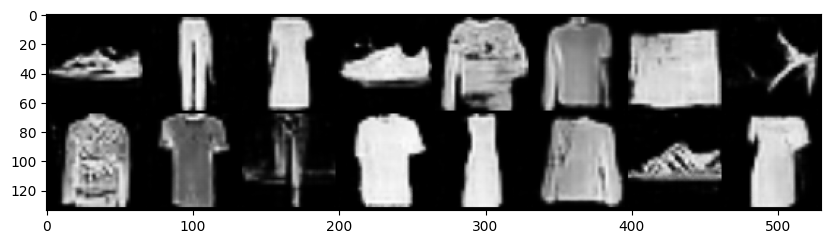

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 30/50 Generator loss =  0.0007775936807904925 Critic loss =  -0.0005682076472463384


  0%|          | 0/469 [00:00<?, ?it/s]

epoch 31/50 Generator loss =  9.115717050109082e-05 Critic loss =  -0.0006229890180803311


  0%|          | 0/469 [00:00<?, ?it/s]

epoch 32/50 Generator loss =  0.00015360321889299828 Critic loss =  -0.000686001231167108


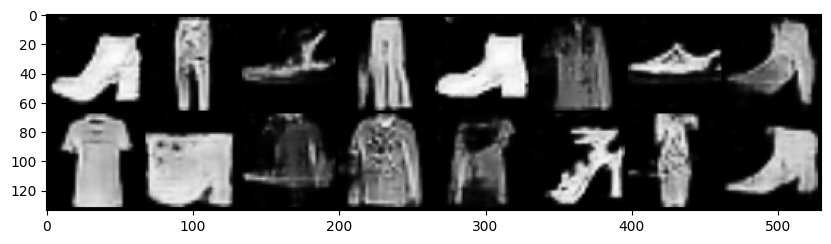

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 33/50 Generator loss =  0.0006713428095713862 Critic loss =  -0.0006009891216180472


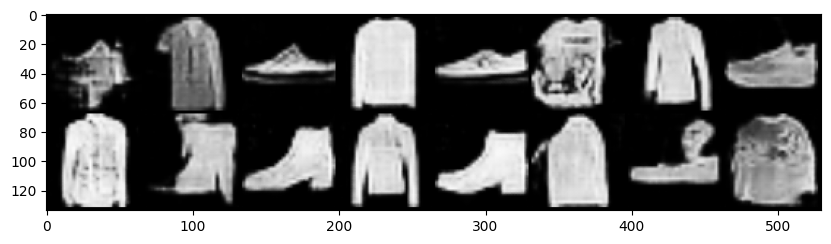

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 34/50 Generator loss =  0.0001802616504463814 Critic loss =  -0.0006943883926375334


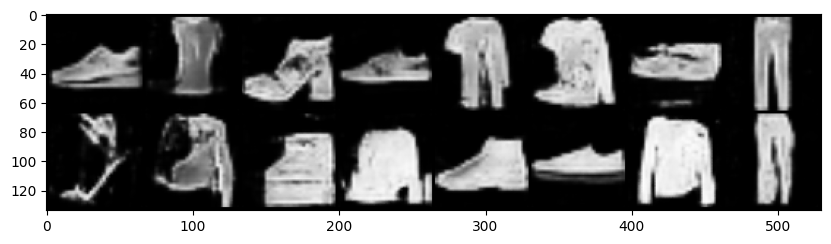

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 35/50 Generator loss =  0.0003414809513193712 Critic loss =  -0.0006652845502662252


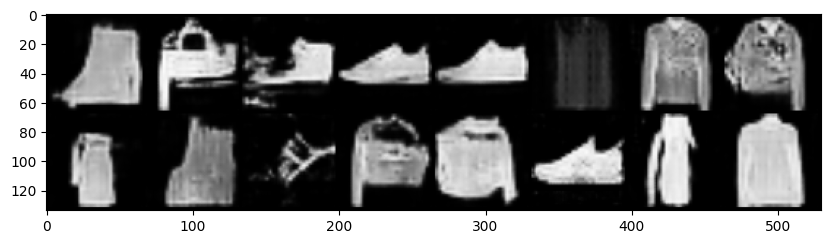

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 36/50 Generator loss =  0.0007880140723450097 Critic loss =  -0.0006734368516438043


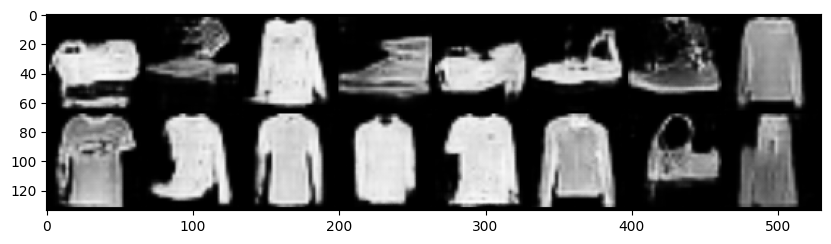

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 37/50 Generator loss =  0.0003152539862244368 Critic loss =  -0.0006926274502963654


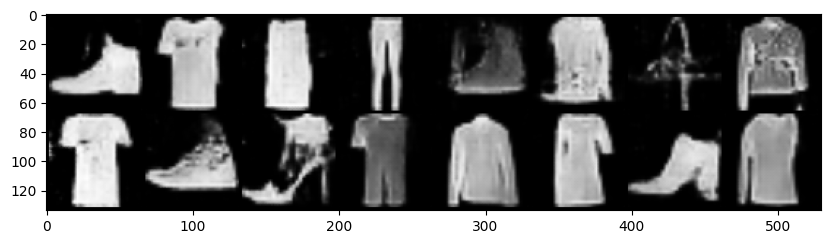

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 38/50 Generator loss =  0.00038644433148634207 Critic loss =  -0.00048602764794567247


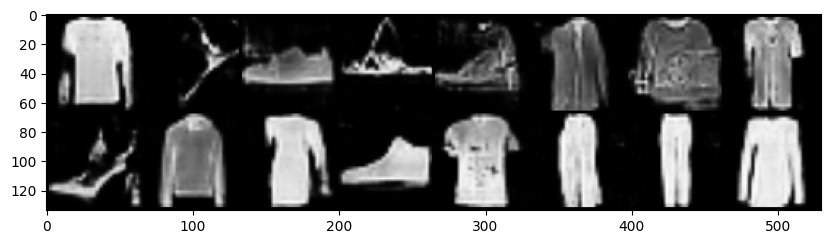

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 39/50 Generator loss =  -5.528750990245388e-05 Critic loss =  -0.0006535041815182293


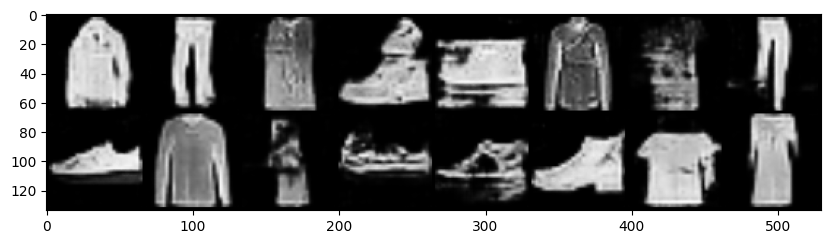

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 40/50 Generator loss =  -0.0001459678353022919 Critic loss =  -0.0007040597228353212


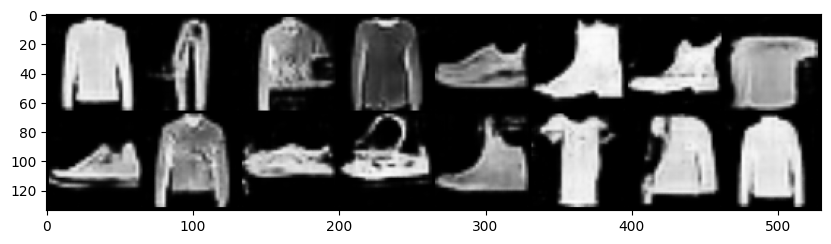

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 41/50 Generator loss =  0.0002652692324571264 Critic loss =  -0.000562044158419058


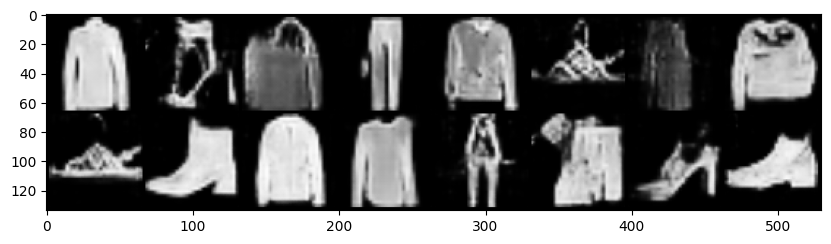

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 42/50 Generator loss =  0.000717777814438094 Critic loss =  -0.00046170704654539065


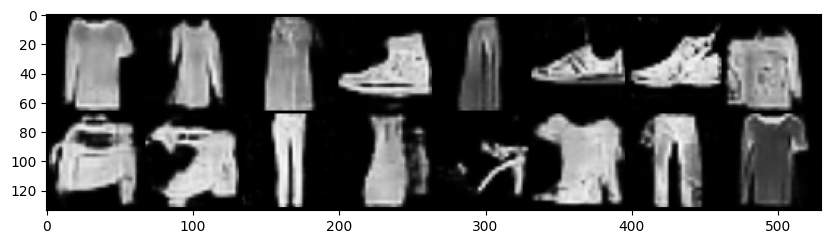

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 43/50 Generator loss =  0.0002668742368470377 Critic loss =  -0.0005481830283777038


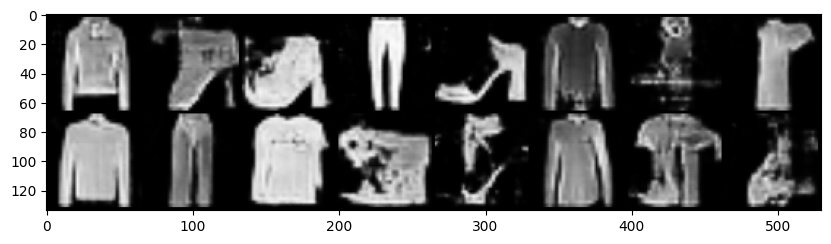

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 44/50 Generator loss =  9.589381754271258e-05 Critic loss =  -0.0005753778064174692


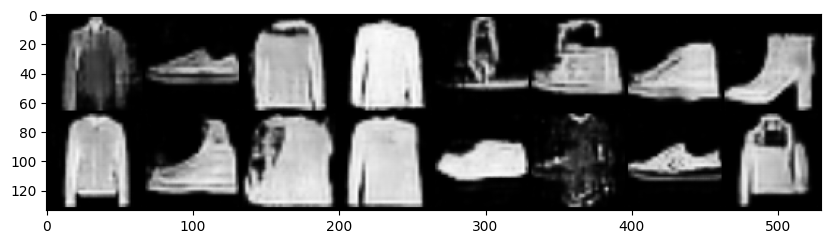

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 45/50 Generator loss =  -1.632719973860773e-05 Critic loss =  -0.0003910531113142652


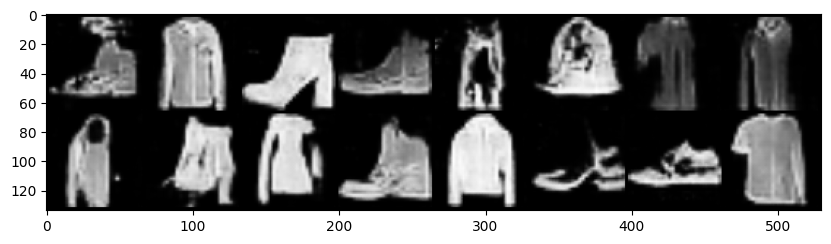

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 46/50 Generator loss =  0.00024316234311569474 Critic loss =  -0.0005090710387301089


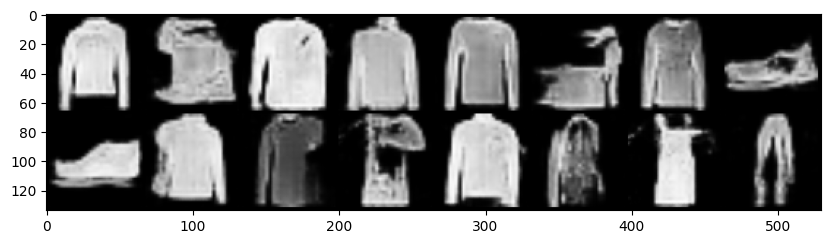

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 47/50 Generator loss =  0.000214070780699187 Critic loss =  -0.0006203669220653932


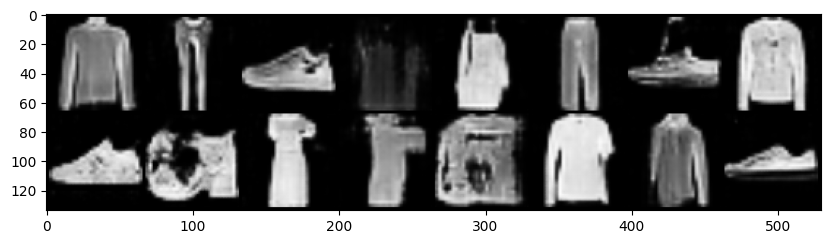

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 48/50 Generator loss =  -1.2813076160466874e-06 Critic loss =  -0.0005337172733949446


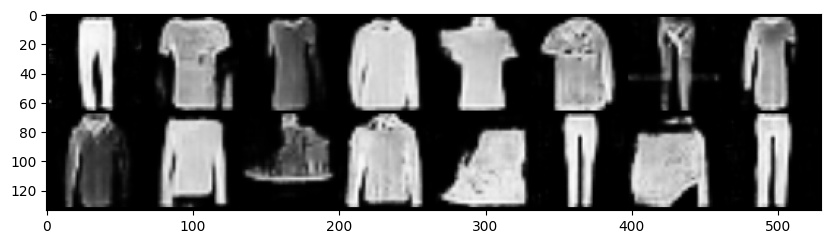

  0%|          | 0/469 [00:00<?, ?it/s]

epoch 49/50 Generator loss =  0.000564188845376216 Critic loss =  -0.0004901727125334588


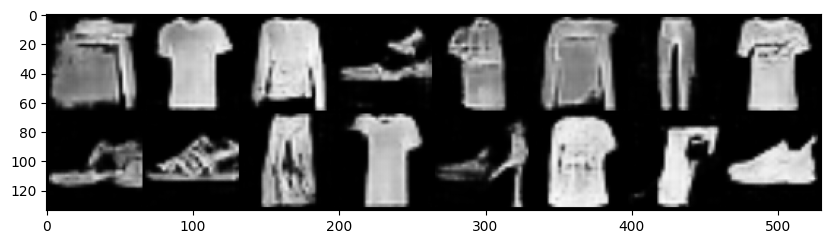

In [12]:
for epoch in range(epochs):
  for real_imgs,_ in tqdm(dataloader):
    crt_total_loss = 0
    gen_total_loss = 0

    images_len = len(real_imgs)
    real_imgs  = real_imgs.to(device)
    for i in range(1):
      crt_opt.zero_grad()
      noise = torch.randn(images_len, z_dim, device=device)
      fake_imgs = gen(noise)
      real_pred   = crit(real_imgs)
      fake_pred   = crit(fake_imgs.detach())
      crt_loss    = torch.mean(fake_pred) - torch.mean(real_pred)
      crt_total_loss += crt_loss
      crt_loss.backward()
      crt_opt.step()
      for p in crit.parameters():
          p.data.clamp_(-clip_value, clip_value)
    noise = torch.randn(images_len, z_dim, device=device)
    fake_imgs = gen(noise)
    gen_opt.zero_grad()
    gen_loss  = - torch.mean(crit(fake_imgs))
    gen_total_loss += gen_loss
    gen_loss.backward()
    gen_opt.step()
  print(f'epoch {epoch}/{epochs} Generator loss = ',gen_total_loss.item()/ len(dataloader), 'Critic loss = ',crt_total_loss.item() / len(dataloader))
  plt.figure(figsize=(10,10))
  plt.imshow(np.transpose(vutils.make_grid(fake_imgs[:16].detach().cpu(), normalize=True),(1,2,0)))
  plt.show()

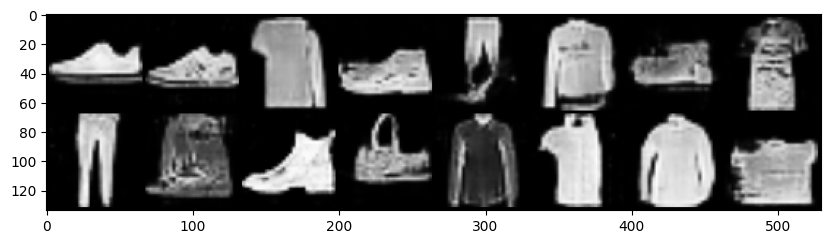

In [15]:
noise = torch.randn(images_len, z_dim, device=device)
fake_imgs = gen(noise)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(vutils.make_grid(fake_imgs[:16].detach().cpu(), normalize=True),(1,2,0)))
plt.show()